In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import glob
import tqdm
from natsort import natsorted
import os, sys, random
#from torchvision.models.video.resnet import r2plus1d_18
from torchvision import models
from imblearn.over_sampling import SMOTE
import skimage
from skimage.exposure import rescale_intensity
from skimage.transform import resize
from networks import Conv3DNet, HalfUNet, Simple_C3D, SparseAutoencoderKL, Pretrained_C2D
from IPython.core.debugger import set_trace
from collections import defaultdict
from itertools import chain

torch.manual_seed(42)

/home/hossay/anaconda3/envs/torch/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="9"

# dataset

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

def oversampling(train_data):
    # separate minority and majority classes
    negative = train_data[train_data.diagnosis=='0']
    positive = train_data[train_data.diagnosis=='1']

    # upsample minority
    pos_upsampled = resample(positive,
     replace=True, # sample with replacement
     n_samples=len(negative), # match number in majority class
     random_state=27) # reproducible results
    # combine majority and upsampled minority
    upsampled = pd.concat([negative, pos_upsampled])
    
    return upsampled.values.T

In [4]:
def normalize_volume(volume):
    p10 = np.percentile(volume, 10)
    p99 = np.percentile(volume, 99)
    volume = rescale_intensity(volume, in_range=(p10, p99))
    m = np.mean(volume, axis=(0, 1, 2))
    s = np.std(volume, axis=(0, 1, 2))
    volume = (volume - m) / s
    return volume

def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

class PETDataset(Dataset):
    def __init__(self, root, split='train', transform=None, target_transform=None):
        self.root = root
        self.transform = transform
        self.target_transform = transform
        self.split = split
        
        (self.frame_dirs, self.target_vals), self.max_depth, self.min_depth = self.get_datasets(split)
        
    def get_datasets(self, split, minor_class='1', suffix='/*/*', seed=42):
        
        frame_dirs = np.array(glob.glob(self.root + suffix))
        #frame_dirs = np.array([ x for x in frame_dirs if Image.open(os.path.join(x, os.listdir(x)[0])).size[0]==128 ])
        target_vals = np.array([ os.path.dirname(s).split('/')[-1] for s in frame_dirs ])
        
        minor_ixs = np.where((target_vals==minor_class))[0].tolist()
        major_ixs = np.where((target_vals!=minor_class))[0].tolist()
        
        np.random.seed(seed)
        
        train_ixs = np.random.choice(
            minor_ixs, int(0.8*len(target_vals)/2), replace=True).tolist() + \
                    np.random.choice(
            major_ixs, int(0.8*len(target_vals)/2), replace=False).tolist()
        np.random.shuffle(train_ixs,)
                
        test_ixs = np.array(list(set(range(len(target_vals)))-set(train_ixs)))
        
        np.random.shuffle(test_ixs)
        
        train_frame_dirs, test_frame_dirs = frame_dirs[train_ixs], frame_dirs[test_ixs]
        train_target_vals, test_target_vals = target_vals[train_ixs], target_vals[test_ixs]
        
#         train_frame_dirs, test_frame_dirs, train_target_vals, test_target_vals = \
#             train_test_split(frame_dirs, target_vals, test_size=0.2, random_state=seed)#, stratify=target_vals)
#         
#         # oversample train dataset
#         train_frame_dirs, train_target_vals = oversampling(
#             pd.DataFrame(np.column_stack([train_frame_dirs, train_target_vals]), columns=['filepath', 'diagnosis']))
        
        data = {'train': [train_frame_dirs, train_target_vals],
                'test':
                [test_frame_dirs, test_target_vals]}
        
        max_depth = max(list(len(os.listdir(x)) for x in frame_dirs))
        min_depth = min(list(len(os.listdir(x)) for x in frame_dirs))

        return data[split], max_depth, min_depth
    
    def load_frames(self, frame_root, seed, transform=None):
        filenames = list(filter(lambda x: x!='DCMs', natsorted(os.listdir(frame_root))))
        
        res = []
        for fn in filenames:
            fn = os.path.join(frame_root, fn)
            img = Image.open(fn).convert('L')
            
            random.seed(seed)
            
            if transform is not None:
                img = transform(img)
            else:
                img = TF.to_tensor(img)
                
            res.append(img.numpy())
            
        res = np.array(res)
        res = torch.from_numpy(res).permute(1,0,2,3)
        
        # zero-padding
        return F.pad(res, pad=(
            0, 0,
            0, 0,
            0, self.max_depth-res.size(1)
        ))
        
        
    def __len__(self):
        return len(self.frame_dirs)
    
    def __getitem__(self, ix):
        seed = random.randint(-sys.maxsize, sys.maxsize)
        data = self.load_frames(self.frame_dirs[ix], seed, self.transform)
        target = torch.tensor(int(self.target_vals[ix])).long()
        target_onehot = torch.eye(2)[target]
        
        image_id = os.path.basename(self.frame_dirs[ix])
        return data, target_onehot, image_id

In [5]:
normalize_func = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5],
#                         std=[0.5, 0.5, 0.5])
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# image transforms
image_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(3),
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        #transforms.ColorJitter(
        #     brightness=0.4,
        #     contrast=0.4,
        #     saturation=0.4,
        #),
        #transforms.RandomRotation(20, resample=Image.BILINEAR),
        normalize_func
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(3),
        transforms.Resize(256),
        transforms.CenterCrop((224, 224)),
        normalize_func,
    ]),
}


In [6]:
from torch.utils.data.sampler import BatchSampler, SequentialSampler

class BalancedBatchSampler(BatchSampler):
    """
    BatchSampler - from a MNIST-like dataset, samples n_classes and within these classes samples n_samples.
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels.numpy()))
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

In [7]:
# train/test dataset & loader
datasets = {
    split : PETDataset(root='/data/DSMC_breast468/full/', split=split,
                       transform=image_transforms[split]) for split in ['train', 'test']
}


batch_sampler = {'train': BalancedBatchSampler(torch.LongTensor(np.array(datasets['train'].target_vals, dtype=int)), 
                                           n_classes=2, n_samples=16),
                 'test': SequentialSampler(datasets['test']),
                }

# train_loader = DataLoader(datasets['train'], batch_sampler=batch_sampler['train'], num_workers=8)
train_loader = DataLoader(datasets['train'], batch_size=8, shuffle=True, num_workers=8)
test_loader = DataLoader(datasets['test'], batch_size=8, shuffle=False, num_workers=8)

dataloaders = dict(zip(['train', 'test'], [train_loader, test_loader]))

In [8]:
def denormalize_img(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    rec = img.permute(1,2,3,0)*torch.FloatTensor(std) + torch.FloatTensor(mean)
    rec = rec.permute(3,0,1,2)
    return rec

236


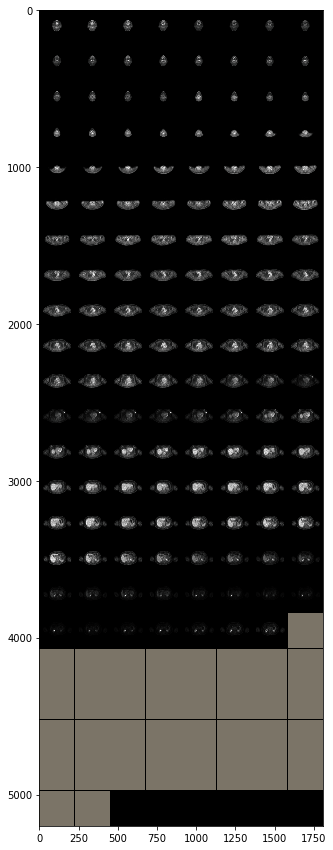

In [9]:
from torchvision.utils import make_grid

img, y_true, image_id = datasets['train'][1]
rec = denormalize_img(img)

plt.figure(figsize=(15,15))
plt.imshow(make_grid(rec.permute(1,0,2,3)).permute(1,2,0))
print(image_id)

In [10]:
rec.max()

tensor(1.)

In [11]:
np.unique(datasets['train'].target_vals, return_counts=True)

(array(['0', '1'], dtype='<U1'), array([187, 187]))

In [12]:
np.unique(datasets['test'].target_vals, return_counts=True)

(array(['0', '1'], dtype='<U1'), array([121,  56]))

# Model

In [13]:
def freeze_layers(layers):
    for child in layers:
        for p in child.parameters():
            p.requires_grad = False

# Replace the first layer with pre-trained sparse-AE weights

In [14]:
# # load pre-trained sparse-AE
# autoencoder = SparseAutoencoderKL()
# autoencoder.load_state_dict(torch.load('./history/sparse_autoencoder_KL.pt'))

# fc_layers = [ m for m in list(autoencoder.encoder.children()) if type(m)==nn.Linear ]
# cascaded_weight = fc_layers[0].weight.t()
# for layer in fc_layers[1:]:
#     cascaded_weight = cascaded_weight.matmul(
#         layer.weight.t()
#     )

# ae_w = cascaded_weight.t().view(-1, 1, 7, 7, 7)
# net = Simple_C3D(ae_w=ae_w)
# net.cuda()

# Transfer learning with 3D ConvNets pre-trained with Kinetics-400

In [15]:
# net = r2plus1d_18(pretrained=True)
# net.fc = nn.Linear(net.fc.in_features, 2)
# freeze_layers(layers=[net.stem, net.layer1, net.layer2])
# net.cuda()

# Transfer learning with 2D ConvNets pre-trained with ImageNet

In [16]:
MODE = 'max'

In [17]:
if MODE == 'min':
    net = Pretrained_C2D(max_depth=datasets['train'].min_depth*3)
elif MODE == 'max':
    net = Pretrained_C2D(max_depth=datasets['train'].max_depth*3)

locator = 0
drop_rate = 0.3

# append dropout at each conv group
for i in range(2,len(net.feature)-1):
    net.feature[i] = nn.Sequential(*(list(net.feature[i].children()) + [nn.Dropout(drop_rate)]))
#     for param in net.feature[i].parameters():
#         param.requires_grad_(False)
    
    locator += 1
    if locator % 2 == 0:
        drop_rate += 0.1
        
net.cuda()

Pretrained_C2D(
  (feature): Sequential(
    (0): ResidualBlock(
      (conv1): BasicBlock(
        (conv): Conv2d(534, 133, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(133, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
      )
      (conv2): BasicBlock(
        (conv): Conv2d(133, 133, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(133, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
      )
      (conv3): BasicBlock(
        (conv): Conv2d(133, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
      )
      (skip): BasicBlock(
        (conv): Conv2d(534, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [18]:
# net = models.resnet101(pretrained=True)

# layers = list(net.children())
# feature_dim = layers.pop(-1).in_features

# # replace early layer
# layers[0] = nn.Conv2d(datasets['train'].max_depth*3, 64, kernel_size=7, stride=2, padding=3, bias=False)
# # layers[1] = nn.BatchNorm2d(64)

# # feature extractor
# feature = nn.Sequential(*layers)


# # replace fc layer to adapt our task
# layers[-1] = nn.Linear(feature_dim, 2)

# # freeze_layers(layers[1:-1])


# net.cuda()

# Transfer learning with pre-trained UNets

In [19]:
# net = HalfUNet(
#     in_channels=3*datasets['test'].max_depth,
#     n_class=2)
# net.cuda()

# Training 3D ConvNet from scratch

In [20]:
# net = Conv3DNet(n_class=2)
# net.cuda()

# training

In [21]:
from collections import Counter
cnts = Counter(datasets['train'].target_vals)
n = len(datasets['train'])
class_weight = [ max(cnts.values())/cnts['0'], max(cnts.values())/cnts['1']]
class_weight = torch.FloatTensor(class_weight)

In [22]:
from losses import FocalLoss

In [23]:
#criterion = nn.CrossEntropyLoss(weight=class_weight).cuda()
cross_entrp_loss = nn.CrossEntropyLoss().cuda()
focal_loss = FocalLoss().cuda()

params = [ p for p in net.parameters() if p.requires_grad ]
optimizer = optim.Adam(params, lr=1e-4, weight_decay=1e-5)

# print(params[0].mean(), print(params[1].mean()))

# optimizer = optim.SGD(params, lr=1e-2, momentum=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [24]:
from sklearn.metrics import accuracy_score, f1_score

In [25]:
def train(net, train_loader, optimizer, criterion, ep, scheduler=None, flatten=False):
    net.train()
    
    running_loss = 0.0
    running_acc = 0.0
    
    y_pred_ = []
    y_true_ = []

    for img, y_true, image_id in tqdm.tqdm(train_loader, desc='train'):
        if MODE == 'min':
            img = img[:,:, :datasets['train'].min_depth]   # slice based-on min_depth

        img = img.cuda()
        y_true = y_true.cuda()
        

        if flatten:
            bs,c,depth,h,w = img.shape
            img = img.view(-1, c*depth, h, w)

        outputs = net(img)
        
        _, y_pred = torch.max(outputs, 1)
        _, y_true = torch.max(y_true, 1)
        
        y_pred_.append(y_pred.detach().cpu().numpy())
        y_true_.append(y_true.cpu().numpy())

        loss = criterion(outputs, y_true)
        
        if hasattr(net, 'weight_discrepancy'):
            loss += net.weight_discrepancy()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = accuracy_score(y_true.cpu(), y_pred.detach().cpu())

        running_loss += loss.item()
        running_acc += acc.item()
                
    running_loss /= len(train_loader)
    running_acc /= len(train_loader)
        
    # f1-score
    f1 = f1_score(list(chain(*y_true_)), list(chain(*y_pred_)))

    print(f'[Train] ep : {ep} loss : {running_loss:.4f} \
          acc : {running_acc:.4f} f1 : {f1:.4f}')
    
    if scheduler is not None:
        scheduler.step()

In [26]:
def evaluate(net, test_loader, criterion, ep, logging=False, flatten=False):
    net.eval()
    
    res = defaultdict(list)

    running_loss = 0.0
    running_acc = 0.0
    
    y_pred_ = []
    y_true_ = []

    for img, y_true, image_id in tqdm.tqdm(test_loader, desc='test'):
        if MODE == 'min':
            img = img[:,:, :datasets['train'].min_depth]   # slice based-on min_depth

        img = img.cuda()
        y_true = y_true.cuda()
        

        if flatten:
            bs,c,depth,h,w = img.shape
            img = img.view(-1, c*depth, h, w)

        with torch.no_grad():
            outputs = net(img)

            _, y_pred = torch.max(outputs, 1)
            _, y_true = torch.max(y_true, 1)
            
            y_pred_.append(y_pred.detach().cpu().numpy())
            y_true_.append(y_true.cpu().numpy())

            loss = criterion(outputs, y_true)
            
            if hasattr(net, 'weight_discrepancy'):
                loss += net.weight_discrepancy()
            
            if logging:
                res['y_test'] += y_true.cpu().numpy().tolist()
                res['y_score'] += torch.softmax(outputs, 1)[:, 1].detach().cpu().numpy().tolist()
                res['y_hat'] += y_pred.detach().cpu().numpy().tolist()
                res['CaseIdx'] += list(image_id)

            acc = accuracy_score(y_true.cpu(), y_pred.detach().cpu())

            running_loss += loss.item()
            running_acc += acc.item()

    running_loss /= len(test_loader)
    running_acc /= len(test_loader)

    # f1-score
    f1 = f1_score(list(chain(*y_true_)), 
                  list(chain(*y_pred_)))
    
    print(f'[Test] ep : {ep} loss : {running_loss:.4f} \
          acc : {running_acc:.4f} f1 : {f1:.4f}')
    
    global BEST_SCORE
    if f1 > BEST_SCORE:
        BEST_SCORE = f1
        torch.save(net.state_dict(), './history/model.pt')
        print(f'Save Best Model in HISTORY \n')
    
    if logging:
        for k,v in res.items():
            res[k] = np.vstack(v)        
        return res
    
    else:
        return None

In [27]:
n_ep = 50
BEST_SCORE = 0.0
criterion = focal_loss

In [28]:
for ep in range(n_ep):
    train(net, dataloaders['train'], optimizer, criterion, ep, scheduler=None, flatten=True)
    evaluate(net, dataloaders['test'], criterion, ep, flatten=True)

test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 0 loss : 0.2098           acc : 0.4654 f1 : 0.4536


test: 100%|██████████| 23/23 [00:16<00:00,  3.01it/s]


[Test] ep : 0 loss : 0.1417           acc : 0.7011 f1 : 0.0678


train:   0%|          | 0/47 [00:00<?, ?it/s]

Save Best Model in HISTORY 



test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 1 loss : 0.1850           acc : 0.4920 f1 : 0.5178


test: 100%|██████████| 23/23 [00:15<00:00,  2.90it/s]


[Test] ep : 1 loss : 1.3696           acc : 0.3533 f1 : 0.4286


train:   0%|          | 0/47 [00:00<?, ?it/s]

Save Best Model in HISTORY 



test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 2 loss : 0.1866           acc : 0.5275 f1 : 0.5665


test: 100%|██████████| 23/23 [00:15<00:00,  2.93it/s]


[Test] ep : 2 loss : 25.8173           acc : 0.3587 f1 : 0.4739


train:   0%|          | 0/47 [00:00<?, ?it/s]

Save Best Model in HISTORY 



test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 3 loss : 0.1738           acc : 0.5559 f1 : 0.5844


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 3 loss : 0.3158           acc : 0.3859 f1 : 0.4301


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 4 loss : 0.1814           acc : 0.5736 f1 : 0.5546


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 4 loss : 2.4296           acc : 0.4348 f1 : 0.3882


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 5 loss : 0.1904           acc : 0.5222 f1 : 0.5623


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 5 loss : 0.2142           acc : 0.5163 f1 : 0.3692


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 6 loss : 0.1711           acc : 0.5585 f1 : 0.5906


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 6 loss : 0.1870           acc : 0.4946 f1 : 0.4686


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 7 loss : 0.1721           acc : 0.5585 f1 : 0.5600


test: 100%|██████████| 23/23 [00:15<00:00,  2.99it/s]


[Test] ep : 7 loss : 0.2749           acc : 0.4457 f1 : 0.5026


train:   0%|          | 0/47 [00:00<?, ?it/s]

Save Best Model in HISTORY 



test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 8 loss : 0.1685           acc : 0.5833 f1 : 0.5761


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 8 loss : 0.1589           acc : 0.6630 f1 : 0.4464


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 9 loss : 0.1527           acc : 0.6374 f1 : 0.6197


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 9 loss : 6.9223           acc : 0.5870 f1 : 0.4328


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 10 loss : 0.1592           acc : 0.5842 f1 : 0.5979


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 10 loss : 0.8695           acc : 0.5326 f1 : 0.3944


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 11 loss : 0.1213           acc : 0.6933 f1 : 0.6797


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 11 loss : 0.2623           acc : 0.5815 f1 : 0.2804


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 12 loss : 0.1458           acc : 0.6498 f1 : 0.6615


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 12 loss : 0.1598           acc : 0.6413 f1 : 0.4107


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 13 loss : 0.1435           acc : 0.6605 f1 : 0.6785


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 13 loss : 0.1584           acc : 0.5543 f1 : 0.4306


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 14 loss : 0.1349           acc : 0.6534 f1 : 0.6505


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 14 loss : 0.1691           acc : 0.5978 f1 : 0.3019


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 15 loss : 0.1008           acc : 0.7323 f1 : 0.7475


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 15 loss : 0.1912           acc : 0.5870 f1 : 0.3968


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 16 loss : 0.1107           acc : 0.7340 f1 : 0.7340


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 16 loss : 0.2673           acc : 0.5163 f1 : 0.4472


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 17 loss : 0.1280           acc : 0.6782 f1 : 0.6809


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 17 loss : 1.0042           acc : 0.5870 f1 : 0.4328


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 18 loss : 0.0908           acc : 0.7509 f1 : 0.7646


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 18 loss : 1.3931           acc : 0.5109 f1 : 0.4029


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 19 loss : 0.1026           acc : 0.7447 f1 : 0.7333


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 19 loss : 0.3787           acc : 0.6413 f1 : 0.4310


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 20 loss : 0.0928           acc : 0.7376 f1 : 0.7366


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 20 loss : 0.2224           acc : 0.4837 f1 : 0.4242


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 21 loss : 0.0930           acc : 0.7722 f1 : 0.7745


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 21 loss : 0.2390           acc : 0.5924 f1 : 0.3590


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 22 loss : 0.0961           acc : 0.7225 f1 : 0.7239


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 22 loss : 0.3248           acc : 0.6087 f1 : 0.3684


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 23 loss : 0.1003           acc : 0.7119 f1 : 0.7081


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 23 loss : 0.6070           acc : 0.4837 f1 : 0.4633


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 24 loss : 0.0708           acc : 0.7899 f1 : 0.8020


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 24 loss : 0.1865           acc : 0.6413 f1 : 0.2143


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 25 loss : 0.0815           acc : 0.8094 f1 : 0.8107


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 25 loss : 0.3219           acc : 0.6467 f1 : 0.3564


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 26 loss : 0.0925           acc : 0.7358 f1 : 0.7374


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 26 loss : 0.3097           acc : 0.6033 f1 : 0.4823


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 27 loss : 0.0684           acc : 0.7996 f1 : 0.7945


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 27 loss : 0.2480           acc : 0.6033 f1 : 0.4065


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 28 loss : 0.0595           acc : 0.8076 f1 : 0.8097


test: 100%|██████████| 23/23 [00:16<00:00,  2.71it/s]


[Test] ep : 28 loss : 0.2088           acc : 0.7011 f1 : 0.5133


train:   0%|          | 0/47 [00:00<?, ?it/s]

Save Best Model in HISTORY 



test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 29 loss : 0.1048           acc : 0.7535 f1 : 0.7500


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 29 loss : 0.2676           acc : 0.6957 f1 : 0.2432


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 30 loss : 0.0926           acc : 0.7624 f1 : 0.7562


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 30 loss : 0.2142           acc : 0.6359 f1 : 0.3964


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 31 loss : 0.0781           acc : 0.7952 f1 : 0.7912


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 31 loss : 0.2367           acc : 0.6359 f1 : 0.4724


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 32 loss : 0.1099           acc : 0.7314 f1 : 0.7238


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 32 loss : 0.1967           acc : 0.6141 f1 : 0.4320


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 33 loss : 0.0891           acc : 0.7996 f1 : 0.7967


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 33 loss : 0.1934           acc : 0.6196 f1 : 0.4262


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 34 loss : 0.0516           acc : 0.8475 f1 : 0.8447


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 34 loss : 0.2751           acc : 0.5217 f1 : 0.4359


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 35 loss : 0.0588           acc : 0.7926 f1 : 0.7936


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 35 loss : 0.2500           acc : 0.6196 f1 : 0.4355


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 36 loss : 0.0753           acc : 0.8129 f1 : 0.8140


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 36 loss : 1.0483           acc : 0.6087 f1 : 0.4462


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 37 loss : 0.1273           acc : 0.7004 f1 : 0.6782


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 37 loss : 0.1933           acc : 0.5978 f1 : 0.4478


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 38 loss : 0.1003           acc : 0.7704 f1 : 0.7850


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 38 loss : 0.2620           acc : 0.5163 f1 : 0.4106


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 39 loss : 0.0845           acc : 0.7660 f1 : 0.7642


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 39 loss : 0.4386           acc : 0.5163 f1 : 0.4106


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 40 loss : 0.0806           acc : 0.7686 f1 : 0.7655


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 40 loss : 0.5866           acc : 0.5761 f1 : 0.4348


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 41 loss : 0.0757           acc : 0.8032 f1 : 0.8032


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 41 loss : 0.2728           acc : 0.5870 f1 : 0.3667


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 42 loss : 0.0778           acc : 0.8032 f1 : 0.8112


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 42 loss : 0.2252           acc : 0.5707 f1 : 0.4552


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 43 loss : 0.0687           acc : 0.8183 f1 : 0.8122


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 43 loss : 0.2330           acc : 0.6522 f1 : 0.3962


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 44 loss : 0.0509           acc : 0.8369 f1 : 0.8356


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 44 loss : 0.2342           acc : 0.6196 f1 : 0.4262


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 45 loss : 0.0498           acc : 0.8236 f1 : 0.8263


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 45 loss : 0.2312           acc : 0.6848 f1 : 0.4727


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 46 loss : 0.0511           acc : 0.8422 f1 : 0.8392


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 46 loss : 0.3956           acc : 0.5272 f1 : 0.4663


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 47 loss : 0.0591           acc : 0.8254 f1 : 0.8219


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 47 loss : 0.1756           acc : 0.6630 f1 : 0.4464


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 48 loss : 0.0486           acc : 0.8395 f1 : 0.8396


train:   0%|          | 0/47 [00:00<?, ?it/s]

[Test] ep : 48 loss : 0.2288           acc : 0.7228 f1 : 0.4742


test:   0%|          | 0/23 [00:00<?, ?it/s]

[Train] ep : 49 loss : 0.0423           acc : 0.8528 f1 : 0.8571


test: 100%|██████████| 23/23 [00:15<00:00,  3.00it/s]

[Test] ep : 49 loss : 0.2717           acc : 0.6250 f1 : 0.4103


In [29]:
# evaluate with best model
net.load_state_dict(torch.load('./history/model.pt'))
res = evaluate(net, dataloaders['test'], criterion, ep=0, logging=True, flatten=True)

test: 100%|██████████| 23/23 [00:15<00:00,  2.97it/s]

[Test] ep : 0 loss : 0.2088           acc : 0.7011 f1 : 0.5133


In [30]:
fpr, tpr, _ = metrics.roc_curve(res['y_test'], res['y_score'])

In [31]:
roc_auc = metrics.auc(fpr, tpr)

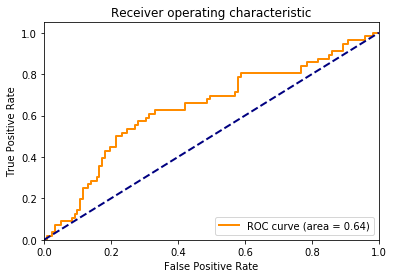

In [32]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [33]:
from sklearn.metrics import classification_report, confusion_matrix
target_names = ['class 0', 'class 1']
print(classification_report(res['y_test'], res['y_hat'], target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.78      0.77      0.77       121
    class 1       0.51      0.52      0.51        56

avg / total       0.69      0.69      0.69       177



In [34]:
cm = confusion_matrix(res['y_test'], res['y_hat'])
cm

array([[93, 28],
       [27, 29]])

In [35]:
tn, fp, fn, tp = confusion_matrix(res['y_test'], res['y_hat']).ravel()
print(f'tn : {tn}, fp : {fp}, fn : {fn}, tp : {tp}')

tn : 93, fp : 28, fn : 27, tp : 29


In [36]:
cm = pd.DataFrame(np.flip(cm), columns=[['PRED']*2, ['1','0']], index=[['ACTUAL']*2, ['1', '0']])
cm

PRED    
            1   0
ACTUAL 1   29  27
       0   28  93

# Visualize CAM

In [37]:
def returnCAM(act_map, weight_softmax, class_idx):
    size_upsample = (224, 224)
    bz, nc, h, w = act_map.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[class_idx].dot(act_map.reshape( (nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam/np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [38]:
params = list(net.parameters())
# get only weight from last layer(linear)
weight_softmax = np.squeeze(params[-2].cpu().data.numpy())

In [39]:
# activation map just before GAP

test_img = datasets['test'][0][0]
c,max_depth,h,w = test_img.shape
test_img = test_img.view(-1, c*max_depth, h, w).cuda()

act_map = net(test_img)

In [40]:
act_map.shape

torch.Size([1, 2])

In [41]:
output_cam = returnCAM(act_map.detach().cpu().numpy(), weight_softmax, class_idx=[0])

ValueError: not enough values to unpack (expected 4, got 2)

In [ ]:
plt.imshow(output_cam[0])

In [ ]:
img_arr = img[1][4].cpu().numpy()
img_arr = 255*(img_arr - img_arr.min())/(img_arr.max()-img_arr.min())

overlap = 0.2 * img_arr + 0.8 * output_cam[0]
plt.imshow(overlap)

In [ ]:
width, height = img_arr.shape
heatmap = cv2.applyColorMap(cv2.resize(output_cam[0], (width, height)), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)/255
img_arr = cv2.cvtColor(img_arr, cv2.COLOR_GRAY2RGB)/255
result = heatmap * 0.4 + img_arr * 0.6
plt.imshow(result)

In [ ]:
y_true[1]

In [ ]:
img.shape

In [ ]:
image_id[1]

In [ ]:
plt.imshow(img[1][10].cpu().numpy())

In [ ]:
plt.imshow(datasets['train'][0][0][:,0].cpu().numpy().transpose(1,2,0))

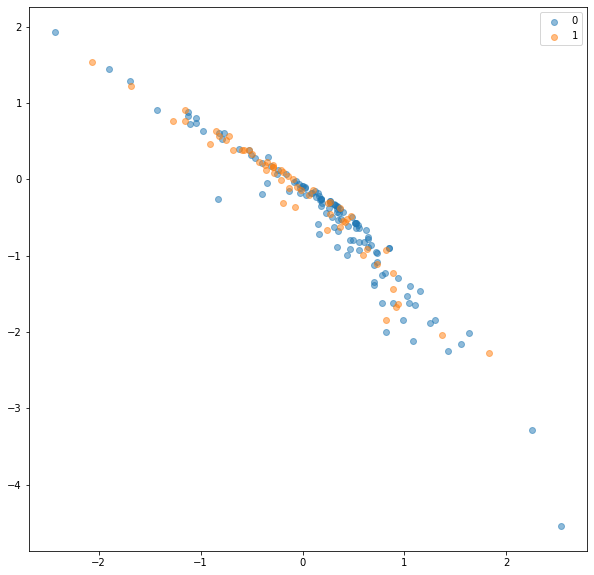

In [42]:
colors = ['#1f77b4', '#ff7f0e']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(2):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(['0', '1'])

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target, _ in dataloader:
            images = images.cuda()
            
            bs,c,max_depth,h,w = images.shape
            images = images.view(-1, c*max_depth, h, w)
              
            outputs = model(images)
            embeddings[k:k+len(images)] = outputs.data.cpu().numpy()
            labels[k:k+len(images)] = target.argmax(1).numpy()
            k += len(images)
    return embeddings, labels

train_loader = dataloaders['test']
train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, net)
plot_embeddings(train_embeddings_otl, train_labels_otl)

In [ ]:
img.shape

In [ ]:
datasets['train'][0][0].shape

In [ ]:
nn.Conv3d()

In [ ]:
import torch.nn as nn
import torch

In [ ]:
m = nn.Conv2d(1*178, 64, kernel_size=7, stride=2, padding=3)

In [ ]:
res['CaseIdx']

In [ ]:
res['y_test'][:10]

In [ ]:
import SimpleITK as sitk
imgName = '/data/DSMC_breast468/'